In [57]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import pandas as pd
import seaborn as sns

%load_ext autoreload
%autoreload 2
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from dnafiber.analysis.ratios import (
    create_swarm_plot,
    create_violin_plot,
    load_experiment,
    load_experiment_predictions,
)
from dnafiber.deployment import run_one_file
from dnafiber.inference import _get_model
from statannotations.Annotator import Annotator

for name, l in logging.root.manager.loggerDict.items():
    if "streamlit" in name:
        l.disabled = True




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
N_FILTER = 200
REF_COL = "Ratio"

Loading sheet: siNT
Loading sheet: siTONSL2 1.125
Loading sheet: siTONSL 2.5
Loading sheet: siTONSL 15
Loading sheet: siTONSL4 1.125
Loading sheet: siTONSL4 2.25
Loading sheet: siTONSL4 15


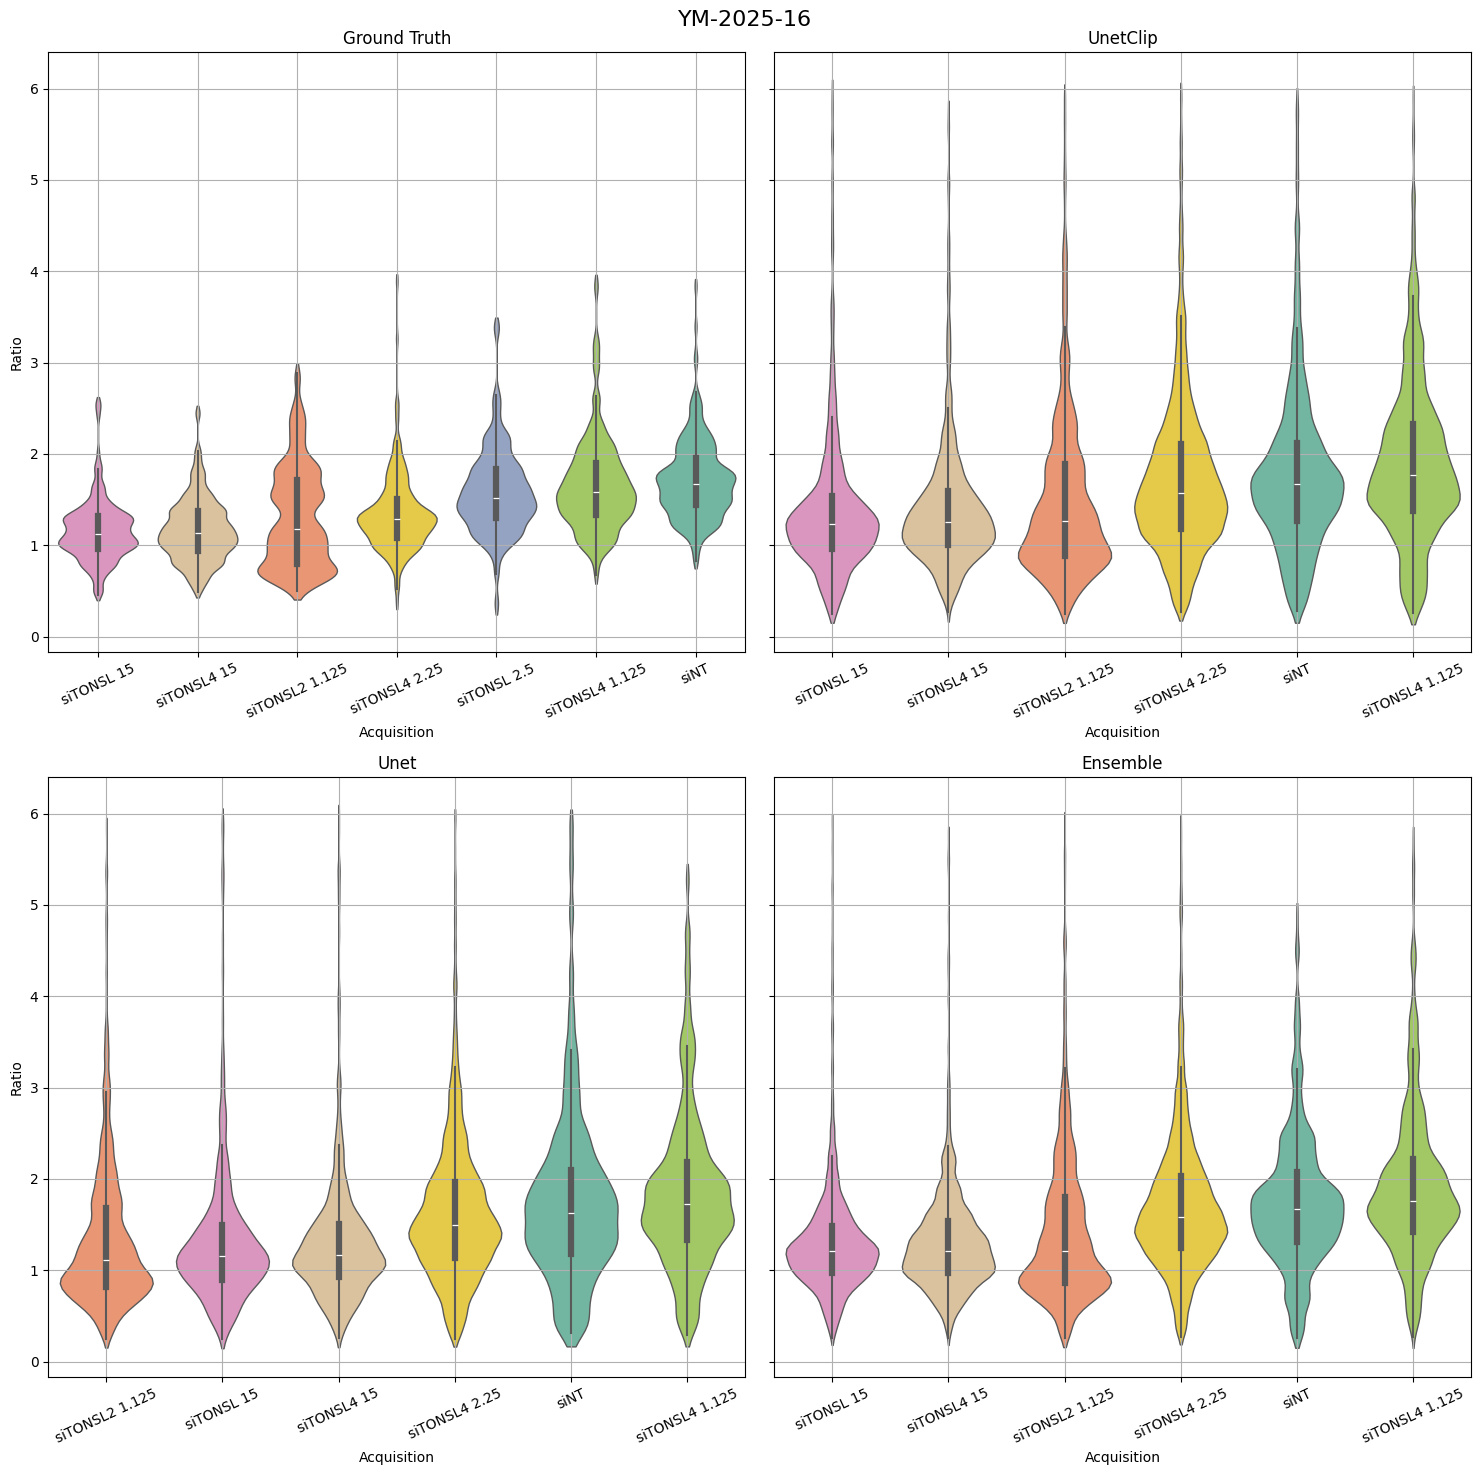

In [59]:
from tools import load_gt, load_pred, filter_per_acquisition, draw, rename_acquisition
root_exp = Path("/home/clement/Documents/data/DNAFiber/GT/")
root_preds = Path("/home/clement/Documents/data/DNAFiber/Output_Reverse/")

all_exps = [f for f in root_exp.glob("*") if f.is_file() and f.suffix == ".xlsx"]


def load_all_models(root: Path, exp, acq_mapping=None, n_filter=N_FILTER, reference_col=REF_COL):
    all_dfs = []
    for m in ["Unet", "UnetClip", "Ensemble"]:
        path = root / m
        df = load_pred(path / exp)
        if acq_mapping is not None:
            df = rename_acquisition(df, acq_mapping)
        
        if n_filter is not None:
            df = filter_per_acquisition(df, n_filter, reference_col=reference_col)
        all_dfs.append(df)
    return all_dfs
rename_mapping = [
    ("SI", "si"),
    ("1_125", "1.125"),
    ("2_25", "2.25"),
    ("-", " "),
    ("_", " "),
    ("siTONSL2 15", "siTONSL 15"),
    ("siTONSL2 2.25", "siTONSL4 2.25"),
]

dfs_preds_A = load_all_models(
    root_preds, all_exps[0].stem, acq_mapping=rename_mapping, n_filter=None, reference_col=REF_COL
)
df_gt_A = load_gt(all_exps[0])

palette = sns.color_palette("Set2", n_colors=len(df_gt_A["acquisition"].unique()))
# Create a color mapping for the acquisitions
acquisition_colors = dict(zip(df_gt_A["acquisition"].unique(), palette))
# Set the color palette for the violin plot

fig, ax = plt.subplots(2, 2, figsize=(15, 15), sharey=True)


draw(df_gt_A, ax=ax[0,0], cmap=acquisition_colors, stats=False)
draw(dfs_preds_A[1], ax=ax[0, 1], cmap=acquisition_colors, stats=False)
draw(dfs_preds_A[0], ax=ax[1, 0], cmap=acquisition_colors, stats=False)
draw(dfs_preds_A[2], ax=ax[1, 1], cmap=acquisition_colors, stats=False)
ax[0, 0].set_title("Ground Truth")
ax[0, 1].set_title("UnetClip")
ax[1, 0].set_title("Unet")
ax[1, 1].set_title("Ensemble")
# Activate the grid for all subplots
ax[0, 0].grid(True)
ax[0, 1].grid(True)
ax[1, 0].grid(True)
ax[1, 1].grid(True) 
plt.suptitle(f"{all_exps[0].stem}", fontsize=16)
plt.tight_layout()
plt.show()

Loading sheet: siNT
Loading sheet: siNT+C5
Loading sheet: siMMS22L
Loading sheet: siMMS22L +C5
Loading sheet: u2os-ctl
Loading sheet: mms22l ko1
Loading sheet: mms22l ko2
['u2os-ctl', 'siMMS22L', 'mms22l ko2', 'siNT+C5', 'siNT', 'mms22l ko1', 'siMMS22L +C5']
Categories (7, object): ['mms22l ko1', 'mms22l ko2', 'siMMS22L', 'siMMS22L +C5', 'siNT', 'siNT+C5', 'u2os-ctl']


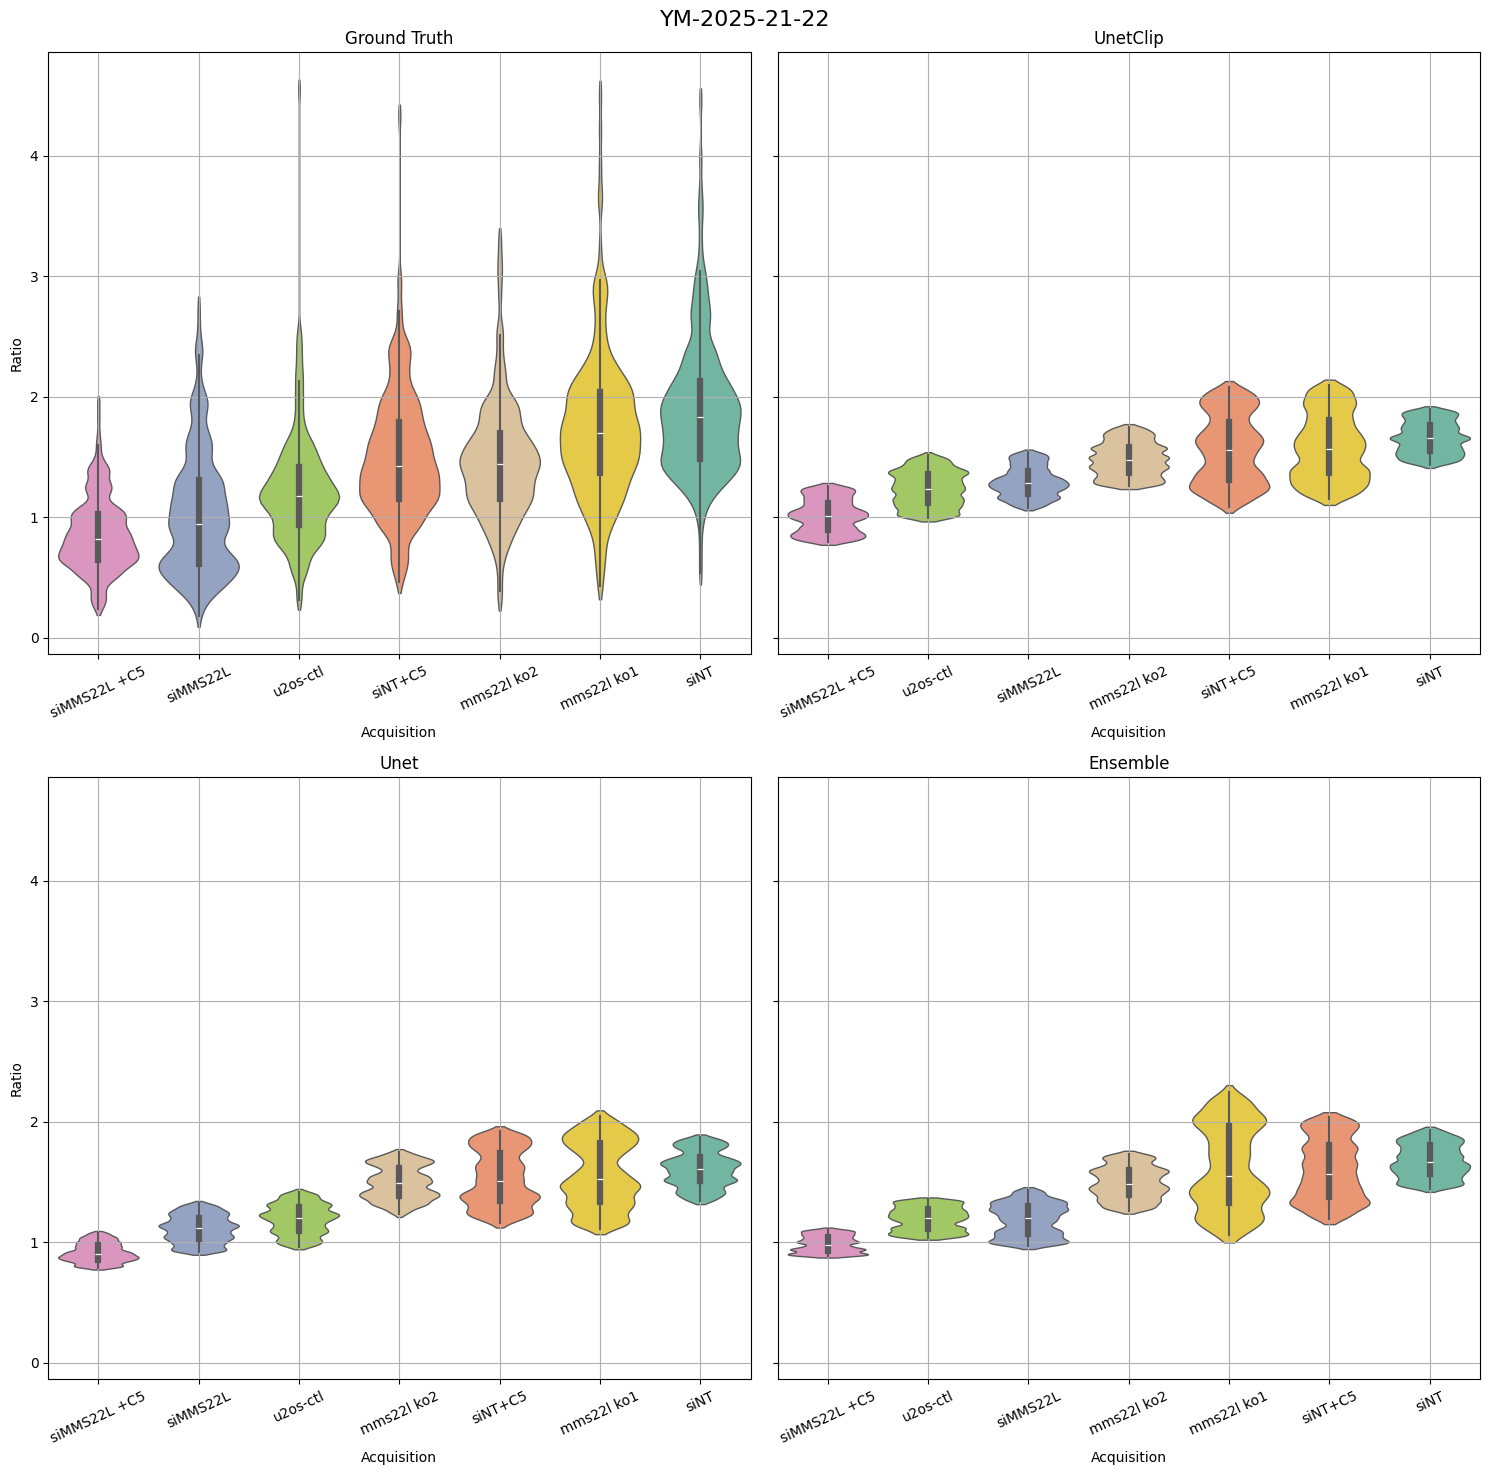

In [60]:

df_gt_A = load_gt(all_exps[1])
df_gt_B = load_gt(all_exps[3])

df_gt_B = pd.concat([df_gt_A, df_gt_B], ignore_index=True)

df_gt_B["acquisition"] = pd.Categorical(
        df_gt_B["acquisition"],
        categories=df_gt_B.groupby("acquisition")["Ratio"]
        .median()
        .sort_values(ascending=True)
        .index,
        ordered=True,
    )

rename_mapping = [
        ("U2OS-CTL", "U2OS-CTL".lower()),
        ("SINT", "siNT"),
        ("MMS22L K0-1", "mms22l ko1"),
        ("siNT +C5", "siNT+C5"),
        ("MMS22L K0-2", "MMS22L Ko2".lower()),
        ("SIMMS22L +C5", "siMMS22L +C5"),
        ("SIMMS22L", "siMMS22L"),
    ]

dfs_preds_B = load_all_models(
    root_preds, "YM-2025-21-22", acq_mapping=rename_mapping, n_filter=N_FILTER, reference_col=REF_COL
)
print(dfs_preds_B[0].acquisition.unique())
palette = sns.color_palette("Set2", n_colors=len(df_gt_B["acquisition"].unique()))
# Create a color mapping for the acquisitions
acquisition_colors = dict(zip(df_gt_B["acquisition"].unique(), palette))
# Set the color palette for the violin plot

fig, ax = plt.subplots(2, 2, figsize=(15, 15), sharey=True)


draw(df_gt_B, ax=ax[0,0], cmap=acquisition_colors, stats=False)
draw(dfs_preds_B[1], ax=ax[0, 1], cmap=acquisition_colors, stats=False)
draw(dfs_preds_B[0], ax=ax[1, 0], cmap=acquisition_colors, stats=False)
draw(dfs_preds_B[2], ax=ax[1, 1], cmap=acquisition_colors, stats=False)
ax[0, 0].set_title("Ground Truth")
ax[0, 1].set_title("UnetClip")
ax[1, 0].set_title("Unet")
ax[1, 1].set_title("Ensemble")
# Activate the grid for all subplots
ax[0, 0].grid(True)
ax[0, 1].grid(True)
ax[1, 0].grid(True)
ax[1, 1].grid(True) 
plt.suptitle("YM-2025-21-22", fontsize=16)
plt.tight_layout()
plt.show()

Loading sheet: siNT
Loading sheet: siBRCA1
Loading sheet: siBRCA2
Loading sheet: siTONSL-D
Loading sheet: siTONS+b1
Loading sheet: siT+B2


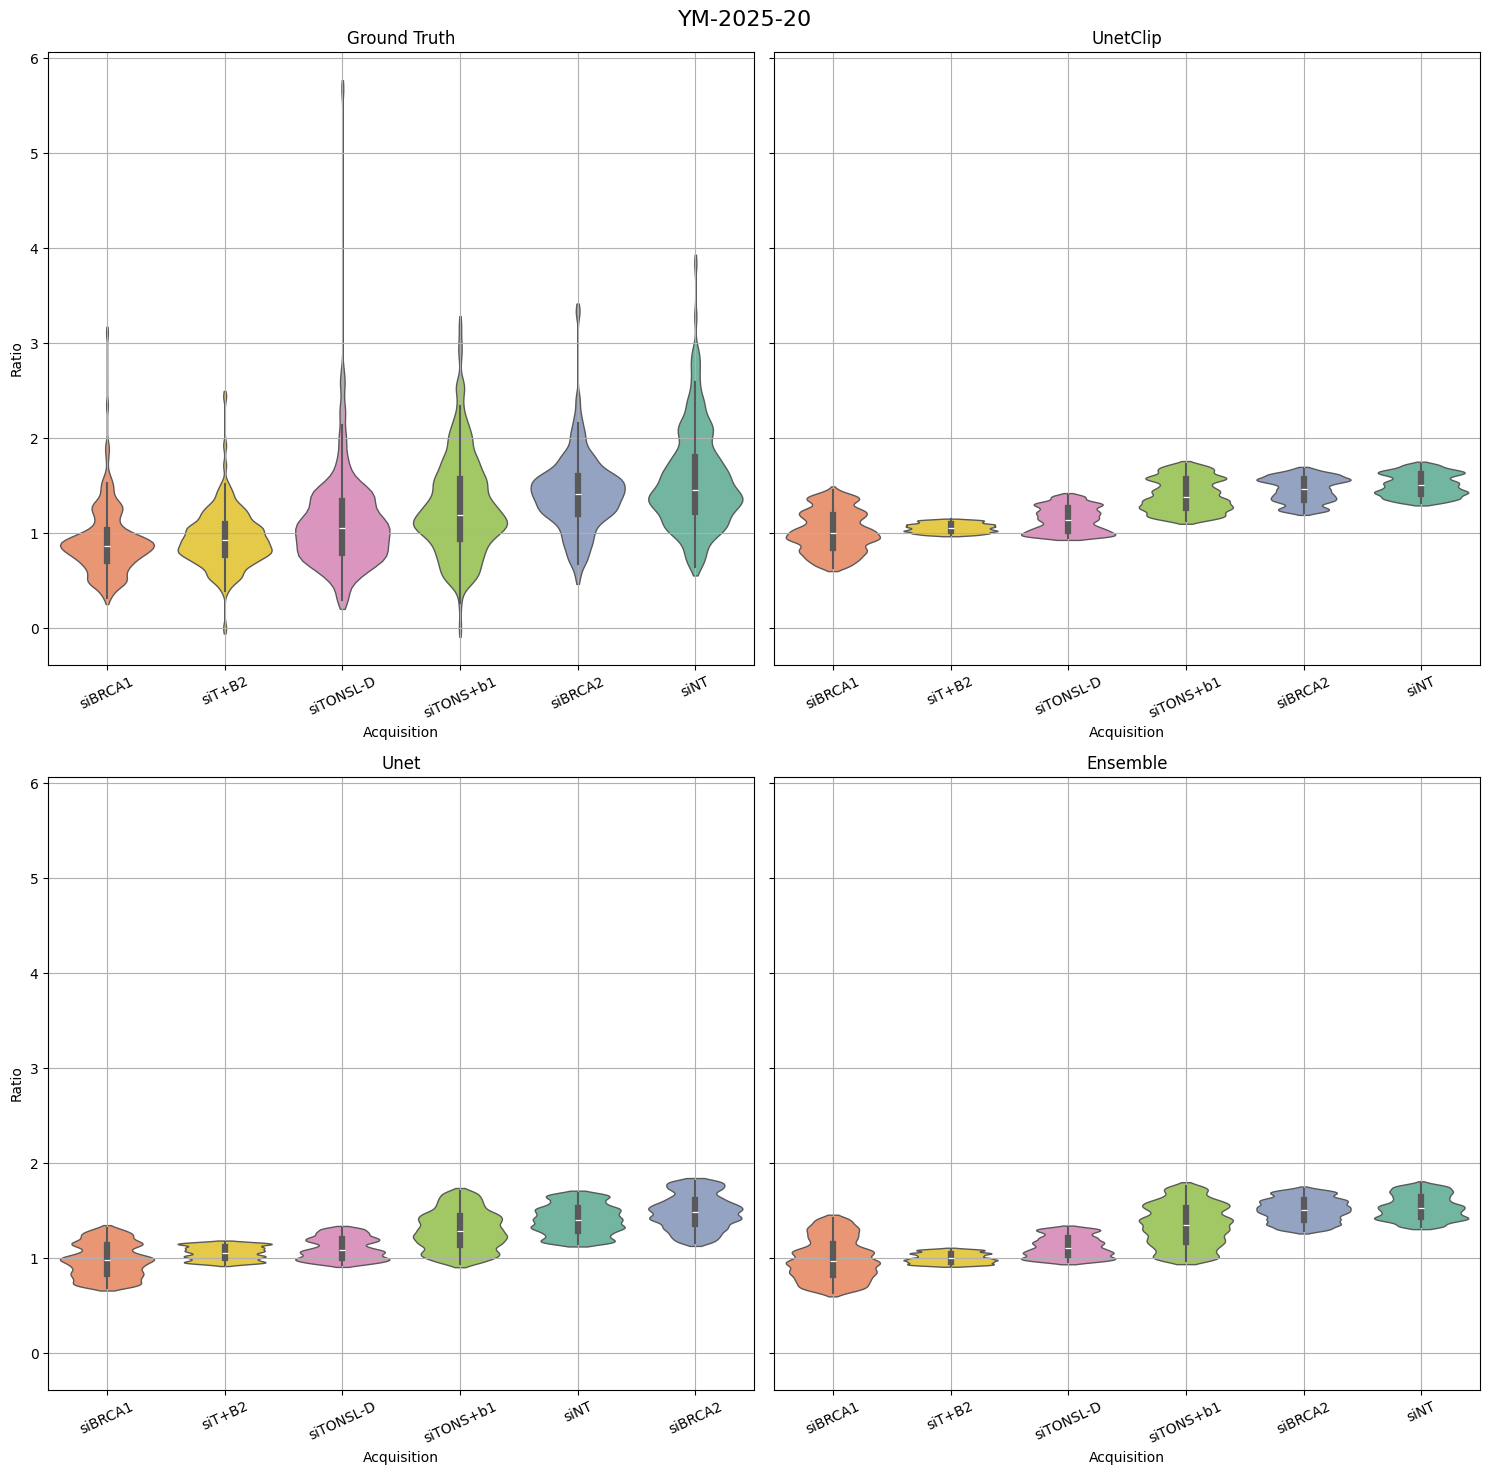

In [61]:
rename_mapping = [
    ("SINT", "siNT"),
    ("SIBRCA1", "siBRCA1"),
    ("SIBRCA2", "siBRCA2"),
    ("SITONSL-D", "siTONSL-D"),
    ("siTONSL-D+siBRCA1", "siTONS+b1"),
    ("siTONSL-D+siBRCA2", "siT+B2")
]

dfs_preds_C = load_all_models(
    root_preds, all_exps[2].stem, acq_mapping=rename_mapping, n_filter=N_FILTER, reference_col=REF_COL)
df_gt_C = load_gt(all_exps[2])

palette = sns.color_palette("Set2", n_colors=len(df_gt_C["acquisition"].unique()))
# Create a color mapping for the acquisitions
acquisition_colors = dict(zip(df_gt_C["acquisition"].unique(), palette))
# Set the color palette for the violin plot

fig, ax = plt.subplots(2, 2, figsize=(15, 15), sharey=True)


draw(df_gt_C, ax=ax[0,0], cmap=acquisition_colors, stats=False)
draw(dfs_preds_C[1], ax=ax[0, 1], cmap=acquisition_colors, stats=False)
draw(dfs_preds_C[0], ax=ax[1, 0], cmap=acquisition_colors, stats=False)
draw(dfs_preds_C[2], ax=ax[1, 1], cmap=acquisition_colors, stats=False)
ax[0, 0].set_title("Ground Truth")
ax[0, 1].set_title("UnetClip")
ax[1, 0].set_title("Unet")
ax[1, 1].set_title("Ensemble")
# Activate the grid for all subplots
ax[0, 0].grid(True)
ax[0, 1].grid(True)
ax[1, 0].grid(True)
ax[1, 1].grid(True) 
plt.suptitle(f"{all_exps[2].stem}", fontsize=16)
plt.tight_layout()
plt.show()

Loading sheet: siNT
Loading sheet: siTONSL
Loading sheet: si53BP1
Loading sheet: si5+si53


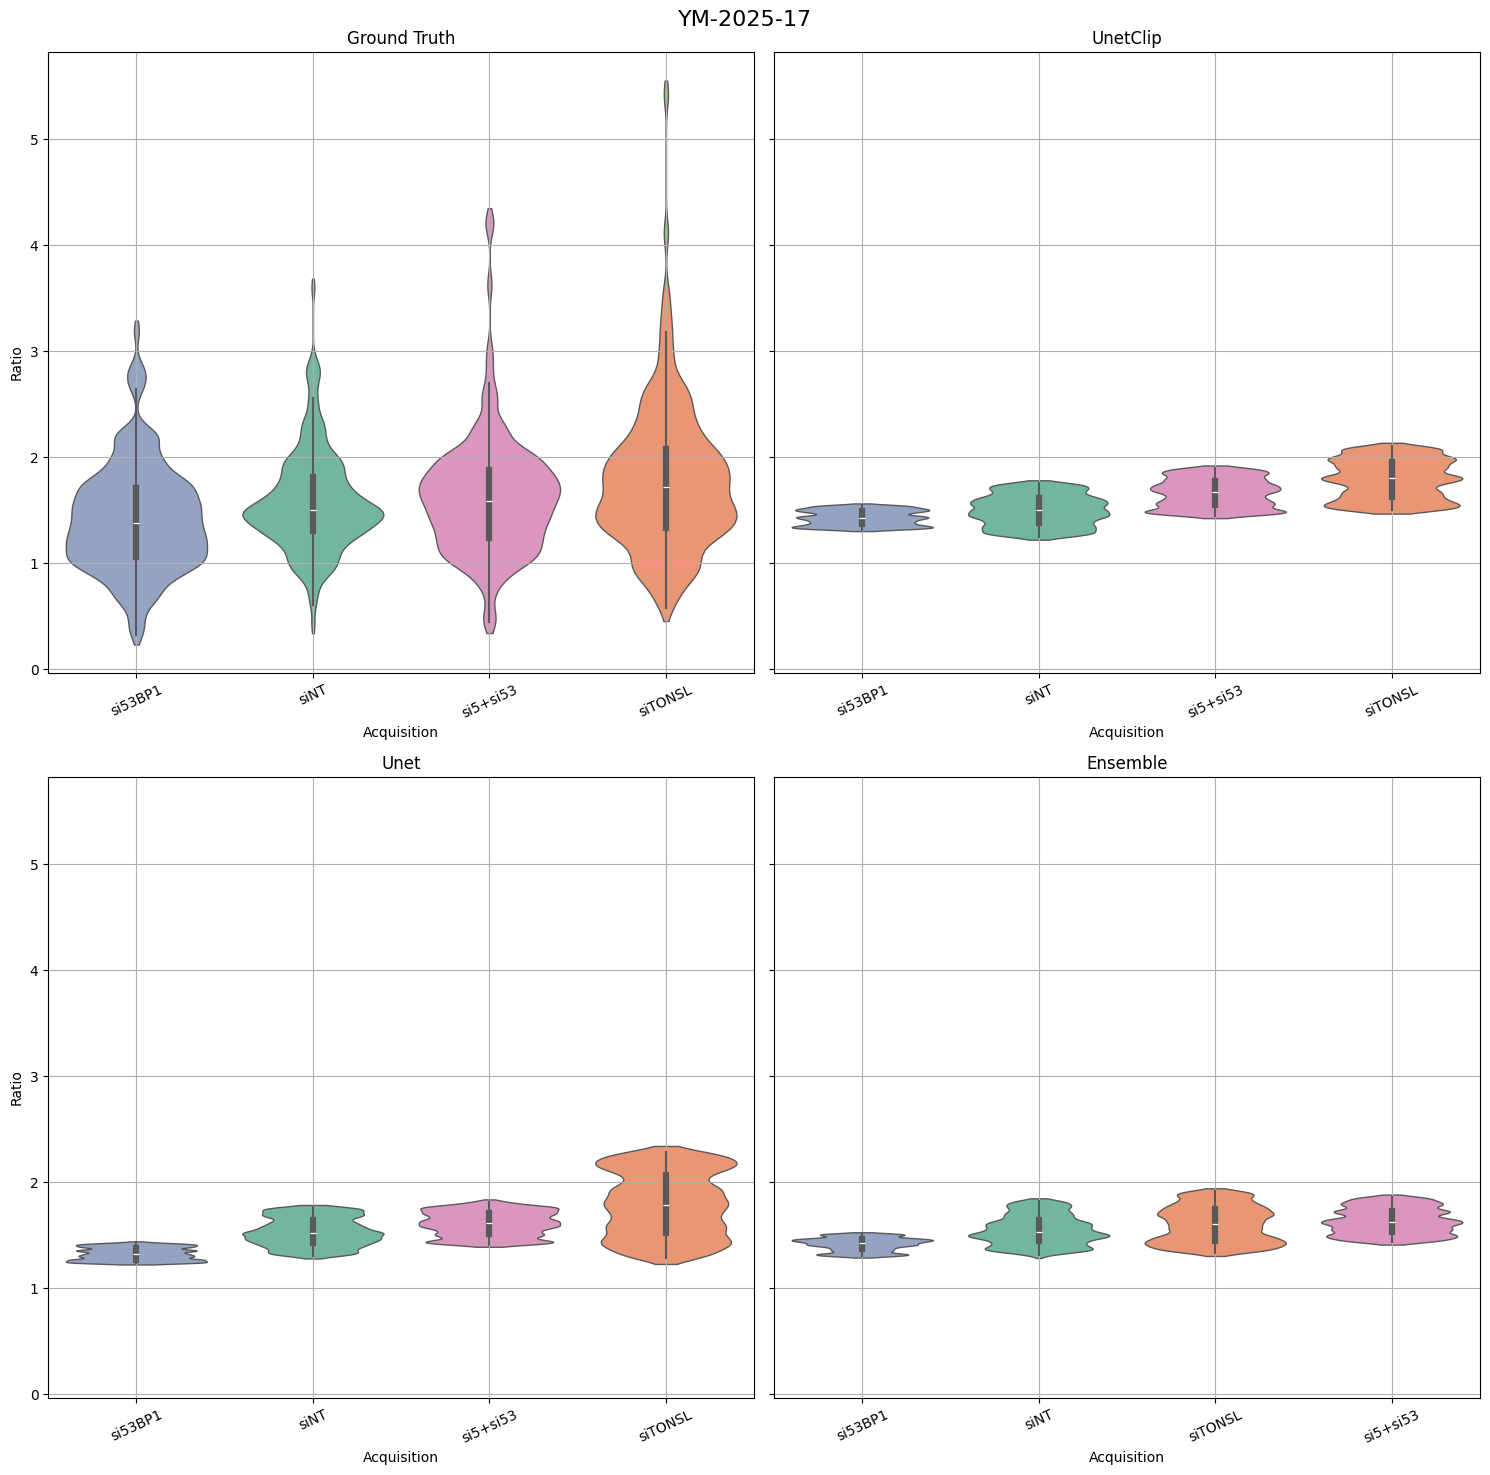

In [62]:
rename_mapping = [
    ("SINT", "siNT"),
    ("SITONSL", "siTONSL"),
    ("SI53BP1", "si53BP1"),
    ("siTONSL+si53BP1", "si5+si53"),
]

dfs_preds_D = load_all_models(
    root_preds, all_exps[4].stem, acq_mapping=rename_mapping, n_filter=N_FILTER, reference_col=REF_COL)
df_gt_D = load_gt(all_exps[4])
palette = sns.color_palette("Set2", n_colors=len(df_gt_D["acquisition"].unique()))
# Create a color mapping for the acquisitions
acquisition_colors = dict(zip(df_gt_D["acquisition"].unique(), palette))
# Set the color palette for the violin plot

fig, ax = plt.subplots(2, 2, figsize=(15, 15), sharey=True)


draw(df_gt_D, ax=ax[0,0], cmap=acquisition_colors, stats=False)
draw(dfs_preds_D[1], ax=ax[0, 1], cmap=acquisition_colors, stats=False)
draw(dfs_preds_D[0], ax=ax[1, 0], cmap=acquisition_colors, stats=False)
draw(dfs_preds_D[2], ax=ax[1, 1], cmap=acquisition_colors, stats=False)
ax[0, 0].set_title("Ground Truth")
ax[0, 1].set_title("UnetClip")
ax[1, 0].set_title("Unet")
ax[1, 1].set_title("Ensemble")
# Activate the grid for all subplots
ax[0, 0].grid(True)
ax[0, 1].grid(True)
ax[1, 0].grid(True)
ax[1, 1].grid(True) 
plt.suptitle(f"{all_exps[4].stem}", fontsize=16)
plt.tight_layout()
plt.show()

/tmp/ipykernel_686063/2644989753.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby("acquisition").median("Ratio").reset_index()
/tmp/ipykernel_686063/2644989753.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby("acquisition").median("Ratio").reset_index()
/tmp/ipykernel_686063/2644989753.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby("acquisition").median(

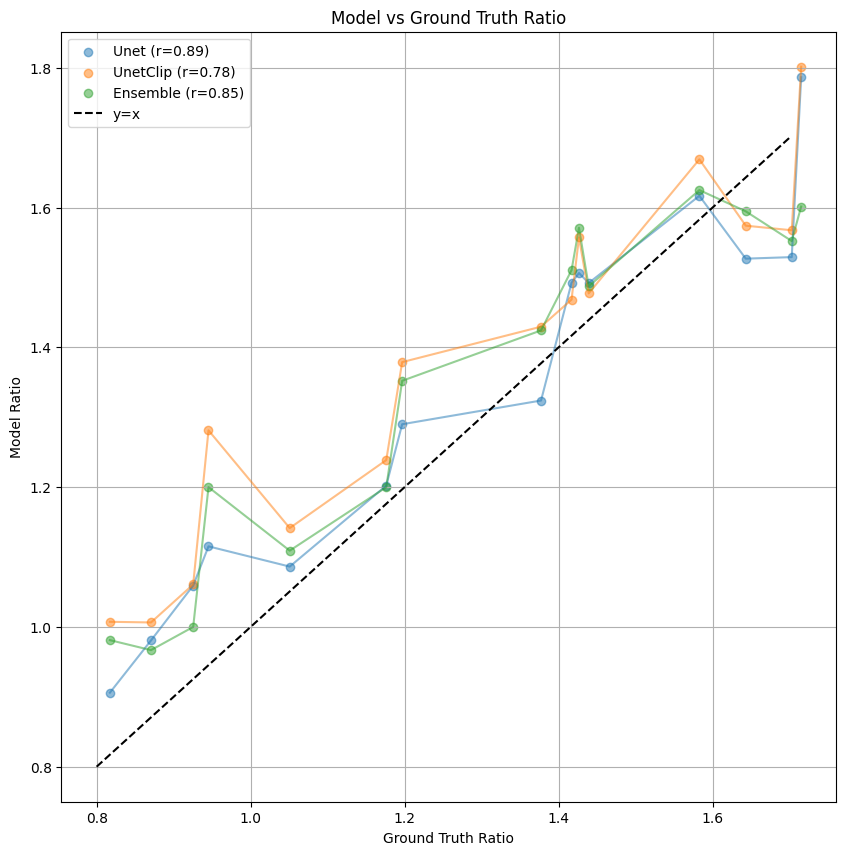

In [63]:
from sklearn.metrics import mean_squared_error, r2_score
gts_concat = pd.concat([df_gt_A, df_gt_B, df_gt_C, df_gt_D], ignore_index=True)
gts_concat["acquisition"] = pd.Categorical(
    gts_concat["acquisition"],
    categories=gts_concat["acquisition"].unique(),
    ordered=True,
)

all_models = []
for i in range(len(dfs_preds_A)):
    df = pd.concat(
        [
            dfs_preds_A[i],
            dfs_preds_B[i],
            dfs_preds_C[i],
            dfs_preds_D[i],
        ],
        ignore_index=True,
    )
    df["acquisition"] = pd.Categorical(
        df["acquisition"],
        categories=gts_concat["acquisition"].unique(),
        ordered=True,
    )
    all_models.append(df)
all_preds = all_models



# We average per acquisition and then scatter plot model vs ground truth (X axis is GT, Y axis is model)
def average_per_acquisition(df):
    # Filter nan values
    return df.groupby("acquisition").median("Ratio").reset_index()

def std_per_acquisition(df):
    # Filter nan values
    return df.groupby("acquisition")["Ratio"].agg(np.std).reset_index()
df_gt_avg = average_per_acquisition(gts_concat)
df_preds_avg = [average_per_acquisition(df) for df in all_preds]

gt_std = std_per_acquisition(gts_concat)
preds_std = [std_per_acquisition(df) for df in all_preds]
acquisitions = df_gt_avg["acquisition"].sort_values(ascending=True).unique()
# We recive the values in the same order
df_gt_avg = df_gt_avg.set_index("acquisition").reindex(acquisitions).reset_index()
df_preds_avg = [df.set_index("acquisition").reindex(acquisitions).reset_index() for df in df_preds_avg]
gt_std = gt_std.set_index("acquisition").reindex(acquisitions).reset_index()
preds_std = [df.set_index("acquisition").reindex(acquisitions).reset_index() for df in preds_std]

xs = np.array(df_gt_avg["Ratio"].values, dtype=float)
ys = [np.array(df["Ratio"].values, dtype=float) for df in df_preds_avg]
xs_std = gt_std["Ratio"].values
ys_std = [df["Ratio"].values for df in preds_std]

argsort = np.argsort(xs)
xs = xs[argsort]
ys = [y[argsort] for y in ys]
ys_std = [y[argsort] for y in ys_std]

fig, ax = plt.subplots(figsize=(10, 10))
for y, label in zip(ys, ["Unet", "UnetClip", "Ensemble"]):
    # Compute the correlation coefficient
    correlation = r2_score(xs, y)

    label = f"{label} (r={correlation:.2f})"
    ax.scatter(xs, y, label=label, alpha=0.5)
    ax.plot(
        xs, y, linestyle="-", alpha=0.5
    )  # Add a line connecting the points

ax.plot([0.8, 1.7], [0.8, 1.7], color="black", linestyle="--", label="y=x")

plt.xlabel("Ground Truth Ratio")
plt.ylabel("Model Ratio")
plt.title("Model vs Ground Truth Ratio")
plt.legend()
plt.grid()
plt.show()


In [64]:
all_preds[0]

,Fiber ID,First analog (µm),Second analog (µm),Ratio,Fiber type,image_name,acquisition,Length,distance
0,1,5.85,11.96,2.044444,double,sitonsl2-2_25-01.czi,NaN,17.81,NaN
1,2,8.32,10.01,1.203125,double,sitonsl2-2_25-01.czi,NaN,18.33,NaN
2,3,8.19,16.77,2.047619,double,sitonsl2-2_25-01.czi,NaN,24.96,NaN
3,8,3.64,10.01,2.750000,double,sitonsl2-2_25-01.czi,NaN,13.65,NaN
4,11,4.16,17.03,4.093750,double,sitonsl2-2_25-01.czi,NaN,21.19,NaN
...,...,...,...,...,...,...,...,...,...
8900,52,6.76,8.71,1.288462,double,siTONSL-03.czi,siTONSL,15.47,0.498773
8901,99,8.58,19.63,2.287879,double,siTONSL-01.czi,siTONSL,28.21,0.500645
8902,52,4.03,9.23,2.290323,double,siTONSL-03.czi,siTONSL,13.26,0.503089
8903,19,6.89,8.84,1.283019,double,siTONSL-03.czi,siTONSL,15.73,0.504215
